# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

### Initialization ###
Starting Spark session:

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
spark

In [3]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [4]:
import urllib.request

In [5]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7f90905e3990>)

Create a first RDD

In [6]:
lines = sc.textFile("apache_logs")

Perform a *transformation*

In [7]:
lineLengths = lines.map(lambda s: len(s))

Perform an *action*

In [8]:
totalLength = lineLengths.reduce(lambda a, b: a + b)

Finally evaluate (laziness!)

In [9]:
totalLength

2360789

### Custom functions

In [10]:
def myFunc(s):
    words = s.split(" ")
    return len(words)

In [11]:
wordCounts = lines.map(myFunc)

In [12]:
wordCounts.max()

43

In [13]:
wordCounts.histogram([0,10,20,30,40,50])

([0, 10, 20, 30, 40, 50], [0, 4901, 4719, 378, 2])

In [14]:
wordCounts.count()

10000

### Map-Reduce pattern

Let's look closer at our log file format:

```
99.158.0.150 - - [18/May/2015:04:05:37 +0000] "GET /images/jordan-80.png HTTP/1.1" 200 6146 "http://www.semicomplete.com/articles/dynamic-dns-with-dhcp/" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/32.0.1700.102 Chrome/32.0.1700.102 Safari/537.36"
```

Count lines containing "Chrome":

In [15]:
chromeLines = lines.map(lambda s: (1 if "Chrome" in s else 0))

In [16]:
counts = chromeLines.reduce(lambda a, b: a + b)

In [17]:
counts

3172

### Key-Value Pairs

Count IP addresses

In [18]:
regex = '([(\d\.)]+)'

In [19]:
import re

In [20]:
ip = re.match(regex, '99.158.0.150 - - ').group(0)

In [21]:
print(ip)

99.158.0.150


In [22]:
ips = lines.map(lambda s: (re.match(regex, s).group(0) ,1))

In [23]:
ipCounts = ips.reduceByKey(lambda a, b: a + b)

Get results

In [24]:
ipCounts.collect()[:10]

[('83.149.9.216', 23),
 ('24.236.252.67', 1),
 ('93.114.45.13', 6),
 ('66.249.73.135', 482),
 ('50.16.19.13', 113),
 ('66.249.73.185', 56),
 ('50.150.204.184', 1),
 ('207.241.237.225', 13),
 ('200.49.190.101', 3),
 ('200.49.190.100', 1)]

In [140]:
ipCounts.take(10)

[('83.149.9.216', 23),
 ('24.236.252.67', 1),
 ('93.114.45.13', 6),
 ('66.249.73.135', 482),
 ('50.16.19.13', 113),
 ('66.249.73.185', 56),
 ('50.150.204.184', 1),
 ('207.241.237.225', 13),
 ('200.49.190.101', 3),
 ('200.49.190.100', 1)]

Sort by values (ascending):

In [26]:
ipCounts.takeOrdered(10, lambda pair: pair[1])

[('24.236.252.67', 1),
 ('50.150.204.184', 1),
 ('200.49.190.100', 1),
 ('24.233.162.179', 1),
 ('220.181.108.153', 1),
 ('112.110.247.238', 1),
 ('66.168.50.129', 1),
 ('180.76.5.27', 1),
 ('93.164.60.142', 1),
 ('94.175.135.116', 1)]

Sort by values (descending):

In [27]:
topIPs = ipCounts.takeOrdered(10, lambda pair: -pair[1])
topIPs

[('66.249.73.135', 482),
 ('46.105.14.53', 364),
 ('130.237.218.86', 357),
 ('75.97.9.59', 273),
 ('50.16.19.13', 113),
 ('209.85.238.199', 102),
 ('68.180.224.225', 99),
 ('100.43.83.137', 84),
 ('208.115.111.72', 83),
 ('198.46.149.143', 82)]

### Plotting

In [28]:
import pandas as pd

# !pip install pandas numpy 
# !pip uninstall numpy pandas -y
# !pip install 'numpy<2' pandas


In [29]:
df = pd.DataFrame(topIPs, columns=['IP', 'Count'])
df

,IP,Count
0,66.249.73.135,482
1,46.105.14.53,364
2,130.237.218.86,357
3,75.97.9.59,273
4,50.16.19.13,113
5,209.85.238.199,102
6,68.180.224.225,99
7,100.43.83.137,84
8,208.115.111.72,83
9,198.46.149.143,82


In [30]:
import matplotlib.pyplot as plt

<Axes: ylabel='IP'>

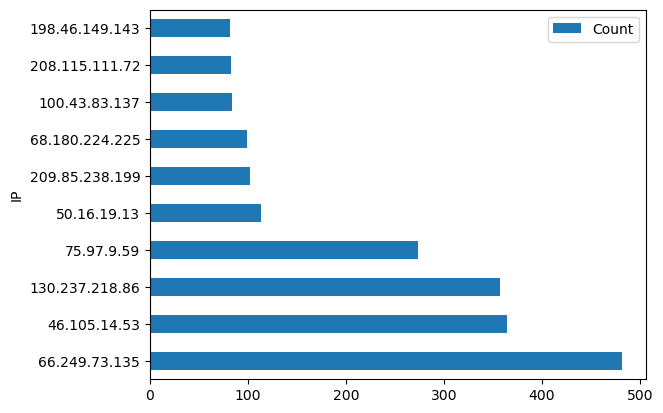

In [31]:
df.plot.barh(x = 'IP')

### Closures and accumulators

Local variables are not passed to closures or functions, they remain local!

In [32]:
counter = 0

# Wrong: Don't do this!!
def increment_counter(x):
    global counter
    counter += x

wordCounts.foreach(increment_counter)

print("Counter value: ", counter)

Counter value:  0


Use *accumulators* instead

In [33]:
accum = sc.accumulator(0)
accum

Accumulator<id=0, value=0>

In [34]:
# Correct way is to use accumulators
def increment_counter(x):
    accum.add(x)

wordCounts.foreach(increment_counter)

print("Counter value: ", accum)

Counter value:  197956


## **Lab 1**

## 1. Plot ranking of the most popular source websites (referrers).

In [35]:
# regex_referer = '"http(.*?)"'

In [36]:
log = '83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"'

In [37]:
# referer = re.search(regex_referer, log).group(0)

In [38]:
referer = log.split('"')[3]

In [39]:
print(referer)

http://semicomplete.com/presentations/logstash-monitorama-2013/


In [40]:
referers = lines.map(lambda s: (s.split('"')[3], 1))
refererCounts = referers.reduceByKey(lambda a, b: a + b)
refererCounts.collect()[:10]

[('-', 4073),
 ('http://www.semicomplete.com/style2.css', 200),
 ('http://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=5&cad=rja&sqi=2&ved=0CFYQFjAE&url=http%3A%2F%2Fwww.semicomplete.com%2Fprojects%2Fxdotool%2F&ei=6cwAU_bRHo6urAeI0YD4Ag&usg=AFQjCNE3V_aCf3-gfNcbS924S6jZ6FqffA&bvm=bv.61535280,d.bmk',
  1),
 ('http://www.semicomplete.com/projects/xdotool/', 656),
 ('http://www.semicomplete.com/blog/tags/C', 13),
 ('http://www.semicomplete.com/', 228),
 ('http://semicomplete.com/blog/geekery/xvfb-firefox.html', 46),
 ('https://www.google.de/', 13),
 ('http://www.google.fr/url?sa=t&rct=j&q=&esrc=s&source=web&cd=5&ved=0CE4QFjAE&url=http%3A%2F%2Fwww.semicomplete.com%2Fblog%2Fgeekery%2Fssl-latency.html&ei=ZdEAU9mGGuWX1AW09IDoBw&usg=AFQjCNHw6zioJpizqX8Q0YpKKaF4zdCSEg&bvm=bv.61535280,d.d2k',
  1),
 ('http://www.semicomplete.com/blog/geekery/ssl-latency.html', 144)]

In [41]:
ordered_refererCounts = refererCounts.takeOrdered(10, lambda pair: -pair[1])

In [42]:
df_referer = pd.DataFrame(ordered_refererCounts, columns=['URL', 'Count'])
df_referer

,URL,Count
0,-,4073
1,http://semicomplete.com/presentations/logstash...,689
2,http://www.semicomplete.com/projects/xdotool/,656
3,http://semicomplete.com/presentations/logstash...,406
4,http://www.semicomplete.com/articles/dynamic-d...,335
5,http://www.semicomplete.com/,228
6,http://www.semicomplete.com/style2.css,200
7,http://semicomplete.com/,164
8,http://semicomplete.com/presentations/logstash...,148
9,http://www.semicomplete.com/blog/geekery/ssl-l...,144


In [43]:
df_referer = df_referer.iloc[1:]

<Axes: ylabel='URL'>

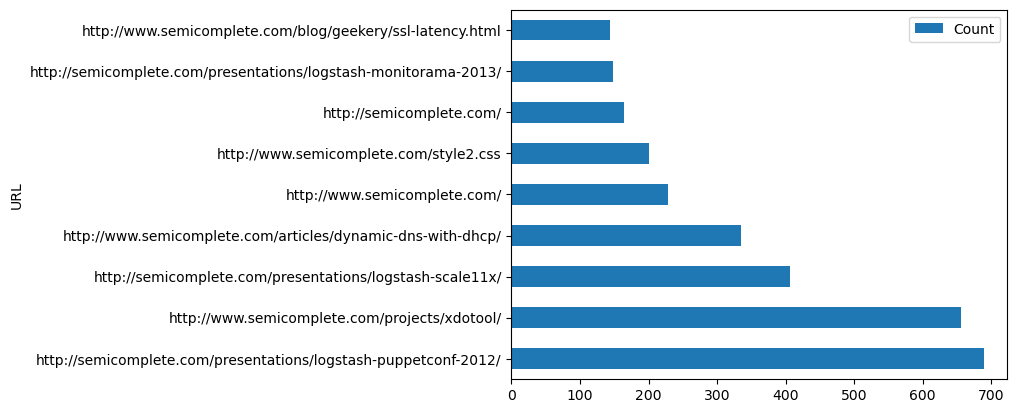

In [44]:
df_referer.plot.barh(x = 'URL')

## 2. Plot ranking of the most downloaded resources by file type (html, css, png, etc.).

In [45]:
file_kind = log.split('"')[1]

In [46]:
print(file_kind)

GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1


In [47]:
regex_file_kind = '\.(\w+)\s' 

In [48]:
file_kd = re.search(regex_file_kind, file_kind).group(1)
print(file_kd)

png


In [49]:
def get_file_kind(s):
    get = s.split('"')[1]
    file_kind = re.search(regex_file_kind, get)
    return file_kind.group(1) if file_kind else '-'

In [50]:
# file_kinds_lines = lines.map(lambda s: (s.split('"')[1], 1))
file_kinds = lines.map(lambda s: (get_file_kind(s), 1))
file_kindsCounts = file_kinds.reduceByKey(lambda a, b: a + b)
file_kindsCounts.collect()

[('js', 250),
 ('svg', 22),
 ('css', 1458),
 ('jpg', 257),
 ('-', 3125),
 ('xml', 37),
 ('txt', 192),
 ('xhtml', 154),
 ('jar', 90),
 ('pdf', 56),
 ('c', 10),
 ('exe', 13),
 ('php', 12),
 ('woff', 1),
 ('pyc', 2),
 ('xsl', 15),
 ('3', 2),
 ('spec', 3),
 ('access', 4),
 ('tex', 4),
 ('gem', 1),
 ('doc', 2),
 ('mk', 1),
 ('java', 1),
 ('deb', 4),
 ('patch', 2),
 ('png', 2331),
 ('ttf', 86),
 ('gif', 184),
 ('jpeg', 4),
 ('ico', 808),
 ('html', 766),
 ('cpp', 1),
 ('lua', 2),
 ('log', 24),
 ('py', 31),
 ('pcap', 1),
 ('swf', 3),
 ('conf', 14),
 ('sh', 6),
 ('gz', 8),
 ('markdown', 1),
 ('m4', 1),
 ('1', 4),
 ('vim', 1),
 ('diff', 1),
 ('xs', 1),
 ('threads', 1),
 ('Jan05', 1),
 ('rb', 2)]

In [51]:
ordered_file_kindsCounts = file_kindsCounts.takeOrdered(10, lambda pair: -pair[1])

In [52]:
df_file_kinds = pd.DataFrame(ordered_file_kindsCounts, columns=['kind', 'Count'])
df_file_kinds

,kind,Count
0,-,3125
1,png,2331
2,css,1458
3,ico,808
4,html,766
5,jpg,257
6,js,250
7,txt,192
8,gif,184
9,xhtml,154


In [53]:
df_file_kinds = df_file_kinds.iloc[1:] #we filter out empty or missing values from the ranking

<Axes: ylabel='kind'>

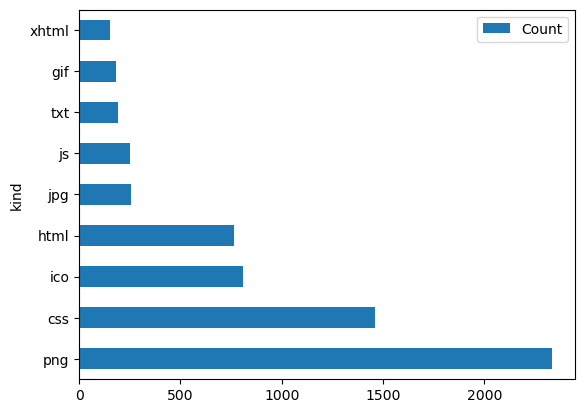

In [54]:
df_file_kinds.plot.barh(x = 'kind')

##  3. Plot the average number of requests per hour, broken down by time of day and HTTP status code.

In [55]:
log_time = log.split('"')[0]
print(log_time)

83.149.9.216 - - [17/May/2015:10:05:03 +0000] 


In [74]:
regex_time = r'\[(\d{2})/\w{3}/\d{4}:(\d{2}):\d{2}:\d{2} [+-]\d{4}\]'
log_time_re = re.search(regex_time, log_time).group(2)
print(log_time_re)

10


In [57]:
log_err = log.split('"')[2]
print(log_err)

 200 203023 


In [58]:
log_err_2 = log_err.split(' ')[1]
print(log_err_2)

200


In [75]:
def get_hour_and_err(s):
    s_time = re.search(regex_time, s.split('"')[0])
    s_day = s_time.group(1)     # dzień miesiąca
    s_hour = s_time.group(2)    # godzina
    
    s_err_and_bytes = s.split('"')[2]
    s_err = s_err_and_bytes.split(' ')[1]

    return (s_day, s_hour, s_err)

In [76]:
get_hour_and_err(log)

('17', '10', '200')

In [77]:
time_err = lines.map(lambda s: (get_hour_and_err(s)))
time_err_list = time_err.collect()

In [79]:
df_time_err = pd.DataFrame(time_err_list, columns=['day', 'hour', 'code error'])
df_time_err

,day,hour,code error
0,17,10,200
1,17,10,200
2,17,10,200
3,17,10,200
4,17,10,200
...,...,...,...
9995,20,21,200
9996,20,21,200
9997,20,21,200
9998,20,21,200


In [80]:
grouped = df_time_err.groupby(['day', 'hour', 'code error']).size().reset_index(name='count')
grouped

,day,hour,code error,count
0,17,10,200,73
1,17,10,404,1
2,17,11,200,107
3,17,11,301,1
4,17,11,304,2
...,...,...,...,...
286,20,19,404,1
287,20,20,200,120
288,20,21,200,79
289,20,21,304,4


In [81]:
avg_per_h = grouped.groupby(['hour', 'code error'])['count'].mean().reset_index()
avg_per_h

,hour,code error,count
0,00,200,111.000000
1,00,301,6.000000
2,00,304,3.333333
3,00,404,3.000000
4,01,200,104.333333
...,...,...,...
101,22,404,2.666667
102,23,200,112.333333
103,23,301,2.333333
104,23,304,2.666667


<Axes: xlabel='hour', ylabel='count'>

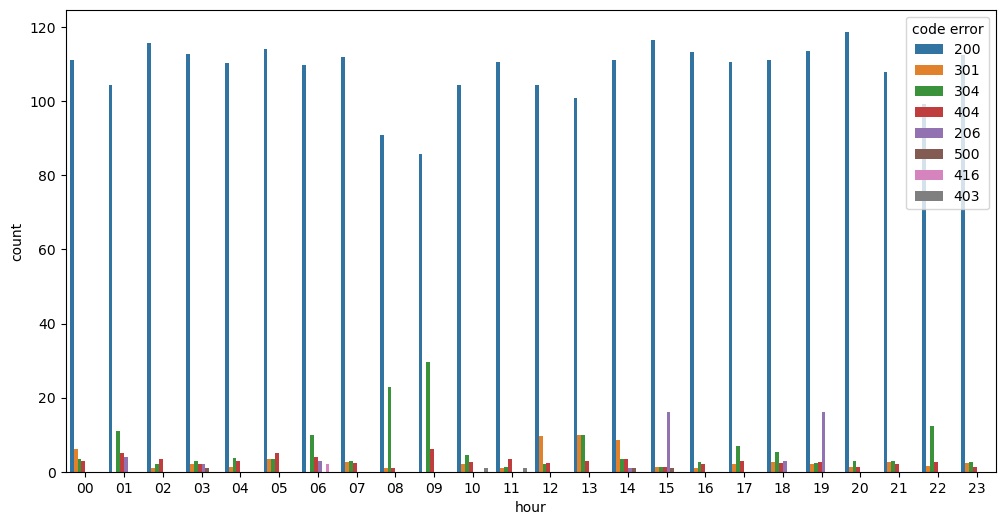

In [86]:
import seaborn as sns
plt.figure(figsize=[12, 6])
sns.barplot(data=avg_per_h, x="hour", y="count", hue="code error")

## 4. Plot a pie chart showing the distribution of device types (desktop, mobile).

We take pairs of IP and device, then select only the unique values.

In [87]:
def get_device(s):
    if "Windows" in s or "X11" in s or ("Mac" in s and "iPad" not in s) or ("Linux" in s and "Android" not in s):
        return "desktop"
    elif "Android" in s or "iPhone" in s:
        return "phone"
    else:
        return "others"        

In [88]:
device_log = log.split('"')[5]
device_log

'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36'

In [89]:
print(get_device(device_log))

desktop


In [152]:
regex = '([(\d\.)]+)'

In [149]:
ip_device = lines.map(lambda s: (re.match(regex, s).group(0), get_device(s))).distinct()
devices_Counts = ip_device.map(lambda s: (s[1], 1)).reduceByKey(lambda a, b: a + b)
devices_Counts = devices_Counts.collect()
devices_Counts

[('desktop', 1325), ('others', 383), ('phone', 86)]

In [150]:
df_device = pd.DataFrame(devices_Counts, columns=['device', 'Count'])
df_device

,device,Count
0,desktop,1325
1,others,383
2,phone,86


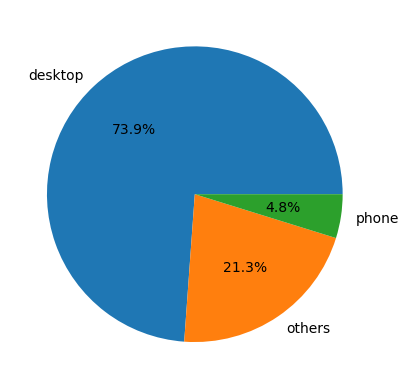

In [151]:
plt.pie(df_device["Count"], labels=df_device["device"], autopct='%1.1f%%')
plt.show()

## 5. Plot a map showing client locations.

In [93]:
regex = '([(\d\.)]+)'

In [94]:
ips = lines.map(lambda s: re.match(regex, s).group(0)).distinct().collect()
ips[:10]

['83.149.9.216',
 '24.236.252.67',
 '93.114.45.13',
 '66.249.73.135',
 '50.16.19.13',
 '66.249.73.185',
 '50.150.204.184',
 '207.241.237.225',
 '200.49.190.101',
 '200.49.190.100']

In [111]:
# !pip install ipinfo

In [100]:
import ipinfo

https://ipinfo.io/blog/geolocation-api-python

In [101]:
access_token = '7d1b248e29949e'
handler = ipinfo.getHandler(access_token)

In [102]:
#test
ip = ips[0]
data = handler.getDetails(ip)
print(data.details)

{'ip': '83.149.9.216', 'city': 'Moscow', 'region': 'Moscow', 'country': 'RU', 'loc': '55.7520,37.6178', 'org': 'AS31133 PJSC MegaFon', 'postal': '101000', 'timezone': 'Europe/Moscow', 'country_name': 'Russia', 'isEU': False, 'country_flag_url': 'https://cdn.ipinfo.io/static/images/countries-flags/RU.svg', 'country_flag': {'emoji': '🇷🇺', 'unicode': 'U+1F1F7 U+1F1FA'}, 'country_currency': {'code': 'RUB', 'symbol': '₽'}, 'continent': {'code': 'EU', 'name': 'Europe'}, 'latitude': '55.7520', 'longitude': '37.6178'}


In [103]:
locations = []
results = handler.getBatchDetails(ips)
for result in results.values():
    lat = result['latitude']
    lon = result['longitude']
    locations.append((float(lat), float(lon)))

locations[:5]

[(55.752, 37.6178),
 (39.0437, -77.4875),
 (14.6407, -90.5133),
 (47.474, -122.261),
 (39.9075, 116.3972)]

In [141]:
# !pip install basemap

In [105]:
from mpl_toolkits.basemap import Basemap
import numpy as np

https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

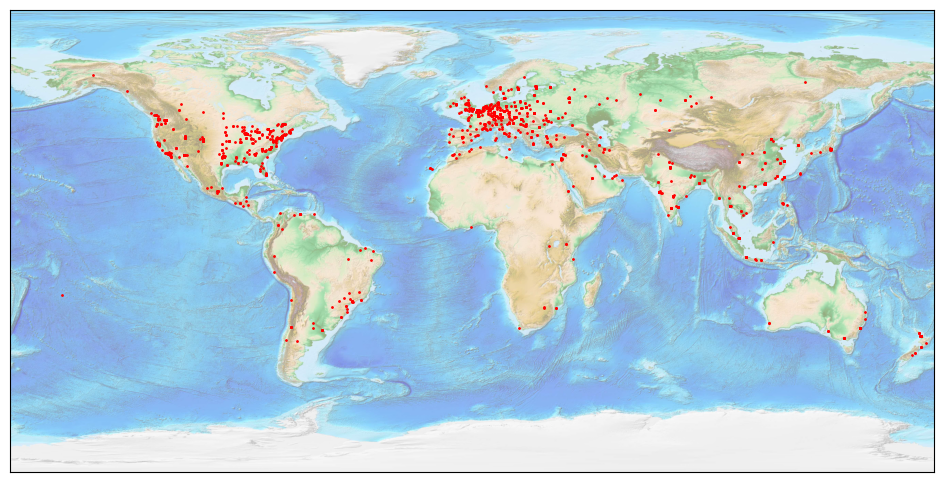

In [110]:
lats = np.array([lat for (lat, long) in locations])
longs = np.array([long for (lat, long) in locations])

fig = plt.figure(figsize=[12, 6])
m = Basemap(llcrnrlat=-90, urcrnrlat=90, 
            llcrnrlon=-180, urcrnrlon=180) 
m.etopo(scale=0.5, alpha=0.5)

x_data, y_data = m(longs, lats)

plt.plot(x_data, y_data, 'ro', markersize=1) 
plt.show()

## 6. Plot the server directory tree, presenting it similarly to the Unix tree command.

In [123]:
regex_path = r'GET\s+(\S+)'
def get_path(s):
    path = s.split('"')[1]
    match = re.search(r'GET\s+(\S+)', path)

    return match.group(1) if match else "-"

In [124]:
get_path(log)

'/presentations/logstash-monitorama-2013/images/kibana-search.png'

In [143]:
paths = lines.map(lambda s: (get_path(s)))
paths_list = paths.distinct().filter(lambda x: x != "-").collect()
paths_list[:10]

['/presentations/logstash-monitorama-2013/images/kibana-search.png',
 '/presentations/logstash-monitorama-2013/images/kibana-dashboard3.png',
 '/presentations/logstash-monitorama-2013/images/sad-medic.png',
 '/presentations/logstash-monitorama-2013/css/fonts/Roboto-Regular.ttf',
 '/presentations/logstash-monitorama-2013/images/kibana-dashboard.png',
 '/presentations/logstash-monitorama-2013/images/github-contributions.png',
 '/presentations/logstash-monitorama-2013/images/1983_delorean_dmc-12-pic-38289.jpeg',
 '/presentations/logstash-monitorama-2013/images/simple-inputs-filters-outputs.jpg',
 '/favicon.ico',
 '/articles/dynamic-dns-with-dhcp/']

https://github.com/techemmy/Python-Intermediate-Projects/blob/master/dir_tree_gen.py

In [144]:
PIPE_PREFIX = "│   "
SPACE_PREFIX = "    "
PIPE = "│"
ELBOW = "└──"
TEE = "├──"

In [145]:
def generate_directory(tree, node, index, len_diritems, prefix, connector):
    tree.append(f"{prefix}{connector} {node['name']}")
    children = node.get('children', [])
    if children:
        if index != len_diritems - 1:
            prefix += PIPE_PREFIX
        else:
            prefix += SPACE_PREFIX
        add_body(tree, children, prefix)
    tree.append(prefix.rstrip())

In [146]:
def add_body(tree, nodes, prefix=""):
    len_nodes = len(nodes)
    for index, node in enumerate(nodes):
        connector = ELBOW if index == len_nodes - 1 else TEE
        generate_directory(tree, node, index, len_nodes, prefix, connector)

In [147]:
def make_tree_from_paths(paths_list):
    root = {}
    for path in paths_list:
        parts = [p for p in path.strip("/").split("/") if p]
        current = root
        for part in parts:
            if part not in current:
                current[part] = {}
            current = current[part]

    def dict_to_nodes(d):
        nodes = []
        for key in sorted(d.keys()):
            node = {'name': key}
            children = dict_to_nodes(d[key])
            if children:
                node['children'] = children
            nodes.append(node)
        return nodes

    return dict_to_nodes(root)

In [148]:
tree_nodes = make_tree_from_paths(paths_list)
tree_lines = []
add_body(tree_lines, tree_nodes)
for line in tree_lines:
    print(line)

├── ?N=A&page=21

├── ?flav=atom

├── ?flav=rss20

├── ?page=1

├── ?page=12

├── ?page=2

├── ?page=25

├── ?page=28

├── ?page=3

├── ?page=35

├── ?page=4

├── ?page=5

├── ?page=6

├── ?page=7

├── about
│   ├── tal:RecentChanges&quo
│
│   └── wal:RecentChanges&quo
│
│
├── admin.php

├── administrator
│   └── index.php
│
│
├── apple-touch-icon-120x120-precomposed.png

├── apple-touch-icon-120x120.png

├── apple-touch-icon-precomposed.png

├── apple-touch-icon.png

├── articles
│   ├── arp-security
│   │   └── arpmitm
│   │
│   │
│   ├── dy
│
│   ├── dynamic-dns-with-dhcp
│
│   ├── efficiency
│
│   ├── openldap-with-saslauthd
│
│   ├── ppp-over-ssh
│   │   └── pppoverssh.png
│   │
│   │
│   ├── ssh-???????????????????
│
│   ├── ssh-security
│
│   └── week-of-unix-tools
│
│
├── blog
│   ├── 2004
│   │   └── May
│   │       └── 03
│   │
│   │
│   │
│   ├── 2006
│   │   ├── Dec
│   │   │   └── 19
│   │   │
│   │   │
│   │   └── May
│   │       └── 04
│   │
│   │
│   │
│   ├── 2006?page